In [6]:
import numpy as np, matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly

In [74]:
number_of_matches = 45
dirr = 'Home_data'
path = f'.\{dirr}\Z{number_of_matches}'
filenumber = 4
signal = np.genfromtxt(f'{path}\z{filenumber}.csv')
sr = 44100
ts = np.arange(len(signal))/sr

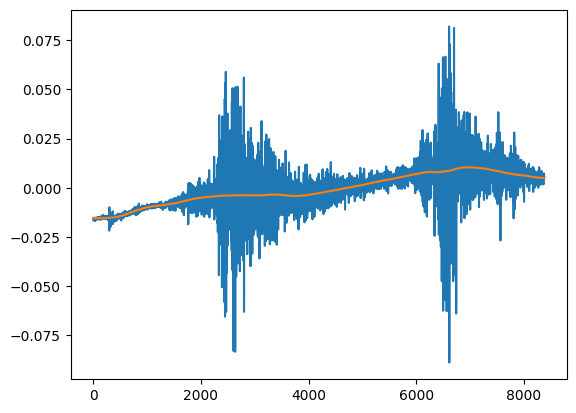

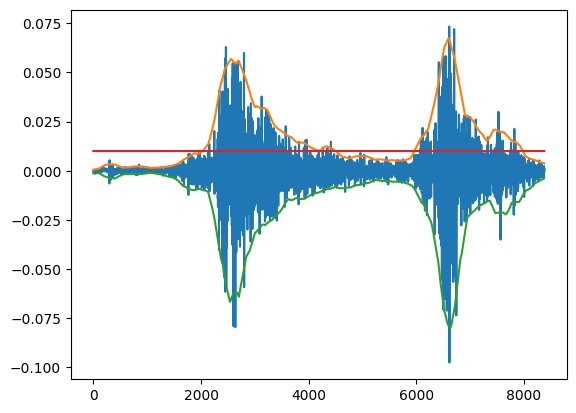

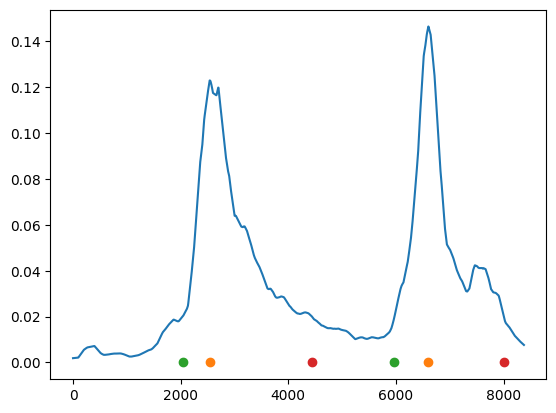

In [82]:
def signal_average(signal, avsize, hop):
    asignal = np.append(np.ones(avsize*hop)*signal[0], signal)
    asignal = np.append(asignal, np.ones(avsize*hop)*signal[-1])
    res = np.sum(np.array([np.roll(asignal, i*hop) for i in range(-avsize,avsize+1)]), axis=0)/(2*avsize + 1)
    return res[avsize*hop:-avsize*hop]
def envelope(signal, avsize):
    asignal = np.append(np.ones(avsize)*signal[0], signal)
    asignal = np.append(asignal, np.ones(avsize)*signal[-1])
    env = np.zeros(len(asignal))
    for i in range(avsize, len(signal)+avsize):
        env[i] = np.amax(asignal[i-avsize:i+avsize])
    return env[avsize:-avsize]
def low_envelope(signal, avsize):
    return -envelope(-signal,avsize)
def find_peaks (averaged_signal):
    slice_idx = len(averaged_signal)//2
    return np.argmax(averaged_signal[:slice_idx]), np.argmax(averaged_signal[slice_idx:])+slice_idx
def find_boundaries(signal, peak_idx, value):
    potential_boundaries = np.nonzero(signal < value)[0]
    if len(potential_boundaries) == 0: print('error: check value')
    idxsorted = np.searchsorted(potential_boundaries, peak_idx)
    left = potential_boundaries[idxsorted - 1]
    right = potential_boundaries[idxsorted]
    return left, right

signal2 = signal_average(signal_average(signal, 200, 1), 50, 1)
plt.plot(signal)
plt.plot(signal2)
plt.show()
proc = signal-signal2 #processed signal
plt.plot(proc)
e1 = signal_average(envelope(proc,50), 150,1)
e2 = signal_average(low_envelope(proc,50), 150,1)
plt.plot(e1)
plt.plot(e2)
plt.plot(np.ones_like(proc)*0.01)
plt.show()
envsum = e1-e2
plt.plot(envsum)
plt.plot(find_peaks(envsum), [0,0], 'o')
l1, r1 = find_boundaries(envsum, find_peaks(envsum)[0], 0.02)
l2, r2 = find_boundaries(envsum, find_peaks(envsum)[1], 0.02)
plt.plot([l1, l2], [0,0], 'o')
plt.plot([r1, r2], [0,0], 'o')

In [84]:
#prepare two signals for prony method
lpeak, rpeak = find_peaks(envsum)

value = 0.02 #this is the hardest part
l1, r1 = find_boundaries(envsum, lpeak, value)
l2, r2 = find_boundaries(envsum, rpeak, value)

left_proc = proc[l1:r1]
left_ts = ts[l1:r1]
right_proc = proc[l2:r2]
right_ts = ts[l2:r2]



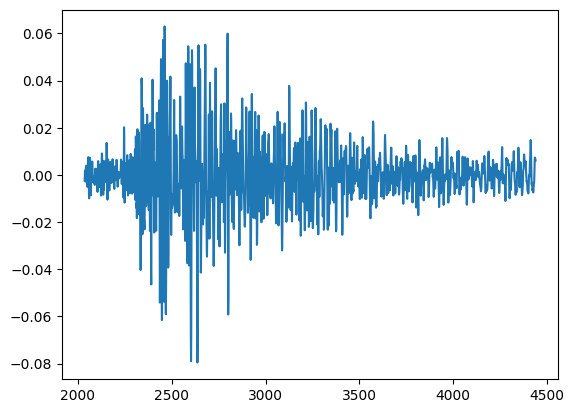

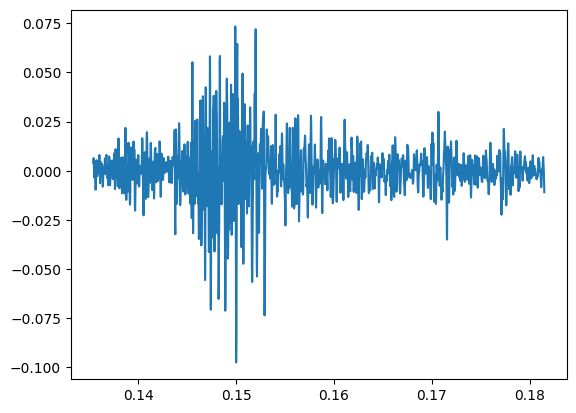

In [95]:
plt.plot(sr*left_ts,left_proc)
plt.show()
plt.plot(right_ts,right_proc)
plt.show()

"""import soundfile as sf
sf.write(f'test_c.wav', np.append(np.zeros(sr//10),left_proc), sr//10)
sf.write(f'test_d.wav', right_proc, int(sr*0.1))"""

In [37]:
#http://sachinashanbhag.blogspot.com/2017/09/prony-method.html
def prony(t, F, m):
	"""Input  : real arrays t, F of the same size (ti, Fi)
			: integer m - the number of modes in the exponential fit
		Output : arrays a and b such that F(t) ~ sum ai exp(bi*t)"""

	# Solve LLS problem in step 1
	# Amat is (N-m)*m and bmat is N-m*1
	N = len(t)
	Amat = np.zeros((N-m, m))
	bmat = F[m:N]

	for jcol in range(m):
		Amat[:, jcol] = F[m-jcol-1:N-1-jcol]
		
	sol = np.linalg.lstsq(Amat, bmat, rcond=None)
	d = sol[0]

	# Solve the roots of the polynomial in step 2
	# first, form the polynomial coefficients
	c = np.zeros(m+1)
	c[m] = 1.
	for i in range(1,m+1):
		c[m-i] = -d[i-1]

	u = poly.polyroots(c)
	b_est = np.log(u)/(t[1] - t[0])

	# Set up LLS problem to find the "a"s in step 3
	Amat = np.zeros((N, m),dtype=complex)
	bmat = F

	for irow in range(N):
		Amat[irow, :] = u**irow
		
	sol = np.linalg.lstsq(Amat, bmat, rcond=None)
	a_est = sol[0]

	return a_est, b_est

def expo(t, a, b):
	return np.real(a*np.exp(b*t))

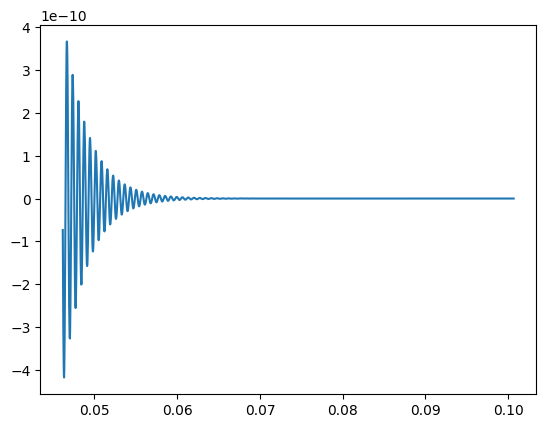

In [91]:
ass, bss = prony(left_ts, left_proc, 100)
abt = np.array([ass, bss]).T
#print(abt)

sumsignal = np.zeros_like(left_ts)
for params in abt:
    sumsignal += expo(left_ts, params[0], params[1])
plt.plot(left_ts, sumsignal)
plt.show()

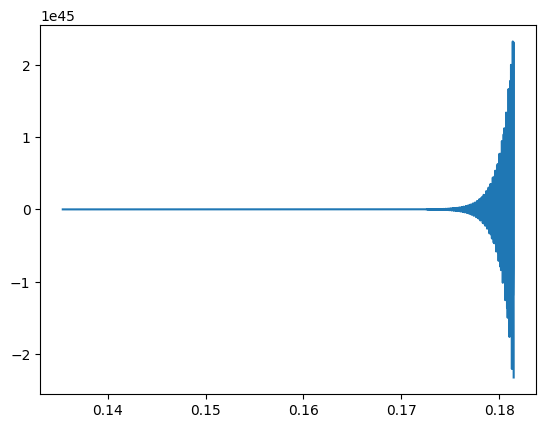

In [86]:
ass, bss = prony(right_ts, right_proc, 1000)
abt = np.array([ass, bss]).T
#print(abt)

sumsignal = np.zeros_like(right_ts)
for params in abt:
    sumsignal += expo(right_ts, params[0], params[1])
plt.plot(right_ts, sumsignal)
plt.show()